
<center> <img src = https://www.smartsenior.se/media/2ljbsnex/booking-com-logo.png
alt="drawing" style="width:400px;"> </center>

<h2 style="text-align: center; font-weight: bold"> Проект: Прогнозирование рейтинга отеля на Booking </h2>

<h3 style="text-align: center; font-weight: bold">----Задача проекта----</h3>

"Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. 
Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. 
Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить."

<h4 style="font-weight: bold">Задача, реализовать готовый рабочий инструмент проверки отелей на предмет накрутки рейтинга

In [20]:
# Импортируем все библиотеки в начале проекта
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import defaultdict
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from geopy.geocoders import Photon

<h4 style="text-align: center">Первичный анализ данных</h4>

In [22]:
# подгружаем дата-сет
hotels = pd.read_csv('data/hotels.csv')

In [23]:
# выведем первые 3 строчки дата-сета
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [24]:
hotels.shape

(386803, 17)

In [25]:
# изучаем основную статистическую информацию о дата-сете о цифровых признаках
hotels.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.00000,386803.000000,384355.000000,384355.000000
mean,498.246536,8.397231,18.538988,2743.992042,17.776985,7.17725,8.396906,49.443522,2.823402
std,500.258012,0.547881,29.703369,2316.457018,21.726141,11.05442,1.636090,3.466936,4.579043
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.00000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.00000,7.500000,48.214662,-0.143649
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.00000,8.800000,51.499981,-0.000250
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.00000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.00000,10.000000,52.400181,16.429233


In [26]:
# изучаем основную статистическую информацию о категориальных признаках
hotels.describe(include='object')

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,386803,386803,386803,386803,386803,386803,386803,386803
unique,1493,731,1492,225,248828,311737,47135,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,3587,1911,3587,184033,95907,26885,3853,1911


In [27]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

Выводы по первичному анализу:
1. В дата-сете представлено 17 признаков в том числе 1 целевой признак.
2. Общее количество строк чуть меньше 400к 
3. Некоторые признаки например `additional_number_of_scoring` в части последнего квартиля, выглядят слегка аномальными
   , но поскольку удаления строк на Kaggle не представляется возможных (из вебинара), будем считать, что данные не являются аномальными.
4. В данных имеются пропущенные значения в признаках `lat` и `lng`
5. Имеются строковые признаки, которые легко превравратить в числовые, а также признак даты `review_date`, который представлен строкой. Интересным кажедся признак `tags`, который является строкой, по своей сути представляет python список.
6. По большей части, данные струкрурированы, целевой признак не имеет пропусков, в данных отсутствуют резко аномальные значения, т.е. в целом значения в признаках не кажутся невероятными, на первый взгляд.

<h3></h3>

<h3 style="text-align:center">Очистка и преобразование данных</h3>

In [28]:
# преобразуем тип данных признака review_date в date_time
hotels.review_date = pd.to_datetime(hotels.review_date)

In [29]:
# Проведем работу над признаком tag, создадим 2 функции, которые преобразуют признак в список, а также функцию которая из списка
# вытянет количество ночей которые провел тот или иной ревьювер


def tags_str_to_list(tag):
    
    """Receives tags feature as a string and returns it as a list
        args: 
            tag (str): receive string kind tag
       returns: 
            tag_list (list): list of tags"""
            
    tags = tag.strip('[]').replace("'", "").split(', ') # clean str from unwanted symbols and turn it to list
    tags_list =  [val.strip() for val in tags] # get rid of spaces in each value of the list
    
    return tags_list
    

def nights_extractor(tag_list):
    
    """Receive tags list and returns number of maximum night stands in a hotel

    Args:
        tag_list (list): _description_

    Returns:
        maximum number of stand nights if there are none in the tag_list returns 0
    """
    
    night_list = []
    for tag in tag_list:
        if 'Stayed' in tag:
            night_list.append(tag.split(' ')[1])
    if night_list:
        return int(max(night_list))
    else:
        return 0

# по горячим следам создадим 2 новых признака tag_list и night_stay
hotels['tag_list'] = hotels.tags.apply(tags_str_to_list)
hotels['nights_stay'] = hotels.tag_list.apply(nights_extractor)

# удалим признак tags, чтобы не дублировать признаки
hotels.drop(labels='tags', axis=1, inplace=True)



In [30]:
# переведем признак days_since_review из строкового значения в числовой
hotels.days_since_review = hotels.days_since_review.apply(lambda x: int(x.split(' ')[0]))

<h4 style="text-weight: bold">Краткий вывод по очистке данных </h4>

1. Перевели данные по признаку `review_date` из `object` в `datetime` 
2. Написали функцию которая преобразует числовой признак `tags` в из типа `object` в тип `list` и добавили отдельный признак `tag_list`
3. Сразу реализовали (по заданию платформы) извлечения признака количества ночей из признака `tag_list`
4. Перевели признак `days_since_review` в числовой из строкового

<h2 style="text-align: center"> Визуализация данных</h2>

c:\Users\AlexUser\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


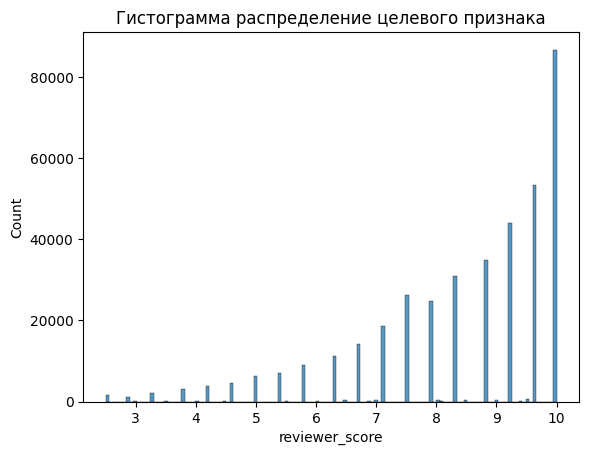

In [31]:
# проверим распределение целевого признака
sns.histplot(hotels.reviewer_score)
plt.title('Гистограмма распределение целевого признака')
plt.show()

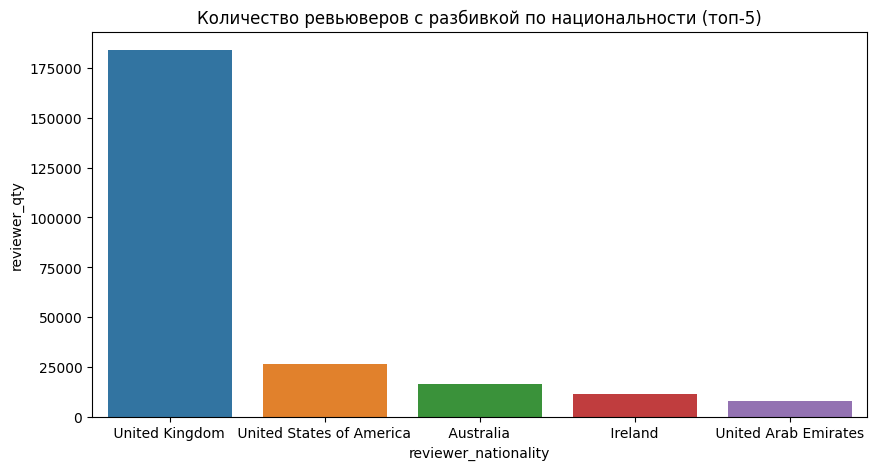

In [32]:
# Выясним ревьювери из какой страны являются доминирующими
plt.figure(figsize=(10, 5))

sns.barplot(hotels['reviewer_nationality'].value_counts().reset_index(name='reviewer_qty').loc[0:4], 
            x='reviewer_nationality',
            y='reviewer_qty')

plt.title('Количество ревьюверов с разбивкой по национальности (топ-5)')
plt.show()

c:\Users\AlexUser\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\AlexUser\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


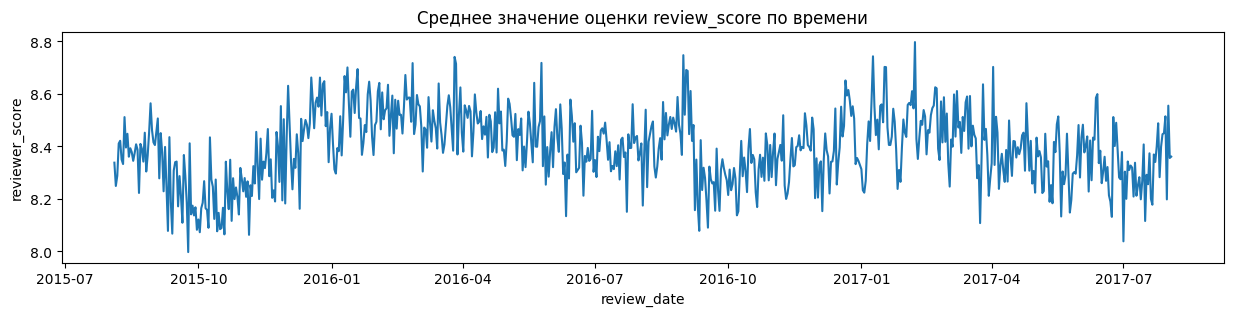

In [33]:
# оценим какие позитивные комментарии имеют больший средний review_score

plt.figure(figsize=(15, 3))
sns.lineplot(hotels.groupby(hotels.review_date)['reviewer_score'].mean().sort_index().reset_index(), 
             x='review_date',
             y='reviewer_score')

plt.title('Среднее значение оценки review_score по времени')

plt.show()

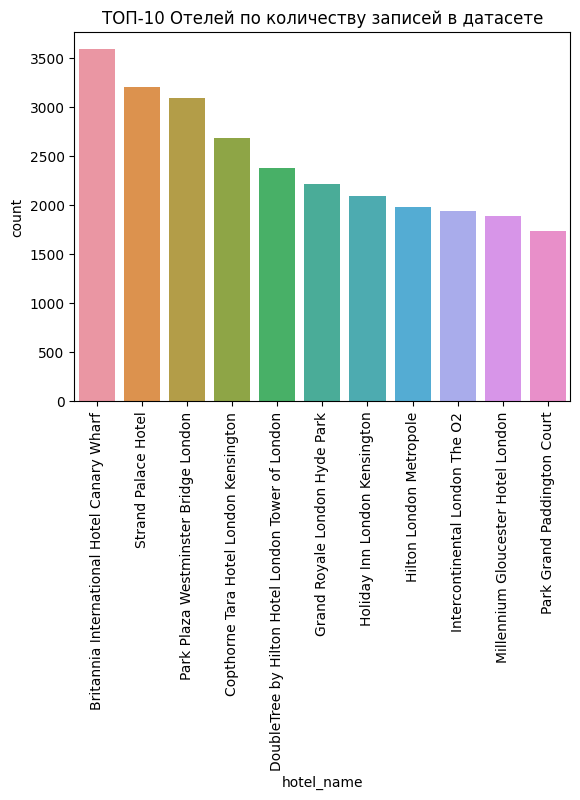

In [34]:
sns.barplot(hotels.hotel_name.value_counts().reset_index().loc[0:10],
            x='hotel_name',
            y='count')
plt.xticks(rotation=90)
plt.title('ТОП-10 Отелей по количеству записей в датасете')
plt.show()

Выводы по визуальному анализу:
1. Целевой признак распределен не по нормальному закону
2. Большинство ревьюверов из британии
3. Согласно графика средней оценки по времени в данных присутствует сезональность
4. Британцы не только являются главными по численности ревьюверами, также и отели Лондона занимают весь то по количеству записей 

<h2 style="text-align:center">Отбор и Преобразование признаков</h2>

In [35]:
# для даты создадим 3 отдельных признака которые можно будет использовать в модели
hotels['month'] = hotels.review_date.dt.month
hotels['day'] = hotels.review_date.dt.day
hotels['year'] = hotels.review_date.dt.year

hotels.drop('review_date', axis=1, inplace=True)

In [39]:
# Посчитаем количество тэгов для тэг листа и создадим отдельный признак
hotels['tags_quantity'] = hotels.tag_list.apply(len)


In [40]:
# С помощью библиотеки geopy найдем недостающие координаты lat и lng т.к. у нас есть адрес для всех отелей
# К сожалению Гугл в нашей стране более не доступен, и возможности получить API нет, придется через OpenStreetMap
# В ней много ограничений, поэтому адреса будут очень примерными

geolocator = Photon(user_agent='my_new_api', timeout=10)

lat_lng_nan_filt = (hotels.lat.isna()) | (hotels.lng.isna())
# находим уникальные адреса отелей для которых нет координат
missed_location_hotels = hotels[lat_lng_nan_filt].hotel_address.unique()

missed_location_hotels_dict = {} # собираем данные по адресам в словарь

for address in missed_location_hotels:
    address_to_geocode = ' '.join(address.split(' ')[0:5:2]) # опытным путем пришел к такой формуле усечения адреса, разброс может быть в рамках одной страны
    location = geolocator.geocode(address_to_geocode)
    missed_location_hotels_dict[address] = [location.latitude, location.longitude]
    
# заполняем пропущенные значения полученными координатами
hotels.loc[lat_lng_nan_filt, 'lat'] = hotels[lat_lng_nan_filt].hotel_address.apply(lambda x: missed_location_hotels_dict[x][0])
hotels.loc[lat_lng_nan_filt, 'lng'] = hotels[lat_lng_nan_filt].hotel_address.apply(lambda x: missed_location_hotels_dict[x][1])



In [41]:
sent_analyzer = SentimentIntensityAnalyzer() # инициализируем класс из библиотеки nltk для оценки тональности текста

In [42]:
# применяем работу sent_analyzer в функциях для построения числовых признаков для подачи в модель
hotels['negative_review_scores'] = hotels.negative_review.apply(lambda x: sent_analyzer.polarity_scores(x)['neg']) 
hotels['positive_review_scores'] = hotels.positive_review.apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])

In [43]:
def tags_tones(x):
    """receives tag_list as a paramenter and return dict of 
       negative and positive marks of the tags

    Args:
        x (list): list of tags

    Returns:
        pos_neg_dict (dict): Dict of neg and pos marks with lists of values
    """
    pos_neg_dict = defaultdict(list)
    
    for i in x:
        pos_neg_dict['neg'].append(sent_analyzer.polarity_scores(i)['neg'])
        pos_neg_dict['pos'].append(sent_analyzer.polarity_scores(i)['pos'])
        
    return pos_neg_dict


hotels['tag_tones_dict'] = hotels.tag_list.apply(tags_tones)

In [44]:
# разделяем признак содержащий словарь на позитивные и негативные оценки по тэгам и будем использовать эти данные в модели
hotels['positive_tags'] = hotels.tag_tones_dict.apply(lambda x: np.mean(x['pos']))
hotels['negative_tags'] = hotels.tag_tones_dict.apply(lambda x: np.mean(x['neg']))

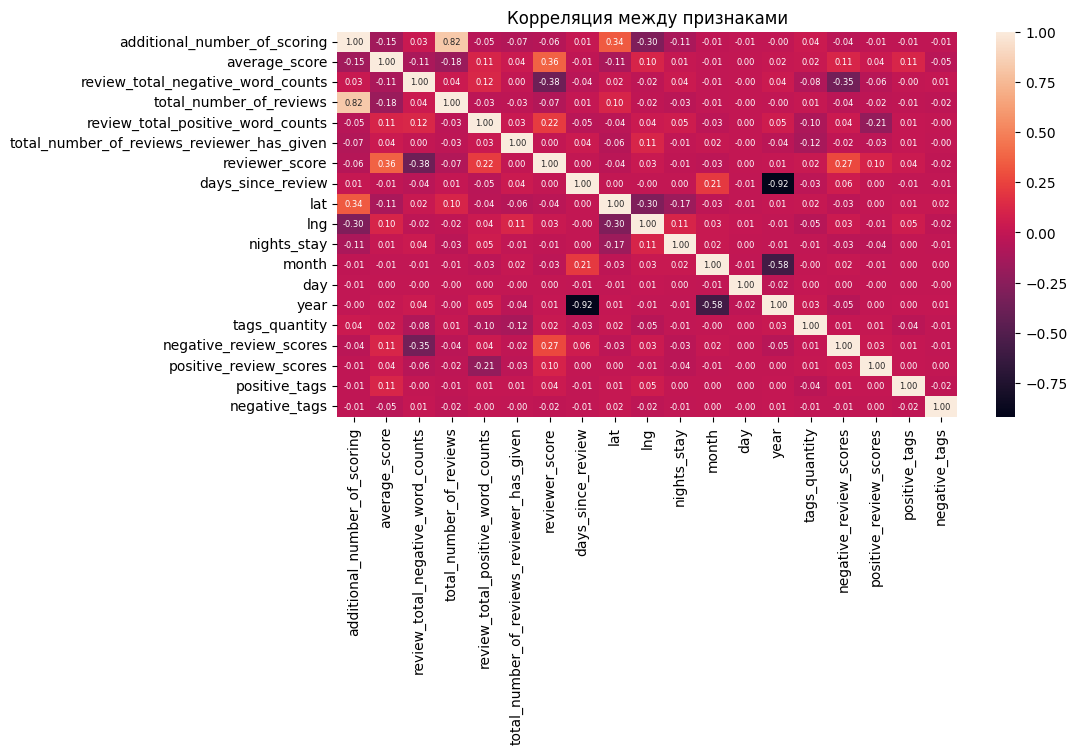

In [46]:
corr_table = hotels.select_dtypes(exclude='object').corr()


plt.figure(figsize=(10, 5))
sns.heatmap(corr_table, annot=True, annot_kws={'size': 6}, fmt=".2f")

plt.title('Корреляция между признаками')


plt.show()


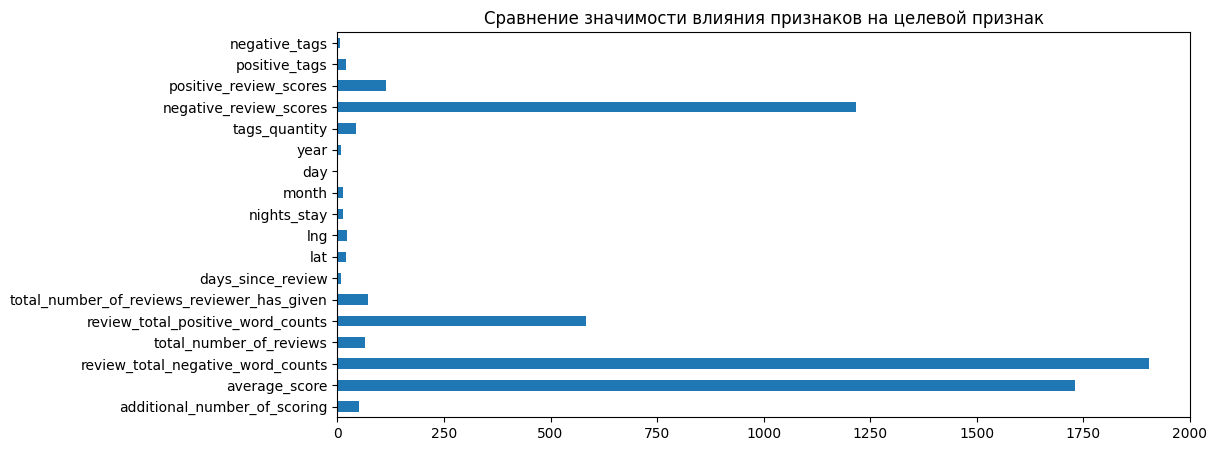

In [45]:
# Оцениваем влияние признаков на целевую переменную

cols = [col for col in hotels.select_dtypes(exclude='object').columns if col != 'reviewer_score']

plt.figure(figsize=[11,5])
pd.Series(f_classif(hotels[cols], hotels['reviewer_score'])[0], index=cols).plot(kind='barh')
plt.title("Сравнение значимости влияния признаков на целевой признак")

plt.show()

<h3>Выводы по отбору и преобразованию признаков:</h3>

1. Создали 3 числовых признака из даты (месяц, год, число)
2. Создали числовой признак количество тэгов 
3. С помощью библиотеки geopy заполнили пропущенные значения по широте и долготе
4. С помощью библиотеки nltk оцениваем тональность негативных и полизивных отзывов, а также оцениваем лист тэгов
5. Исходя из корреляционной матрицы видно что признаки year и days_since_review сильно коррелированы, однако на результаты модели в нашем случае они не сыграли
6. Провели оценку влияния признаков на целевой признак с помощью f_classif и выяснили что признак с наибольшей F-статистикой являет 
review_total_negative_word_counts


<h3 style = "text-align: center; font-weight: bold"> Переходим к блоку удаления категориальных принаков и обучения модели </h3>

In [47]:
# дублируем датафрейм в отдельную переменную, чтобы не проходить все циклы заново в случае если потребуется корректировка в исходном df
hotels_dupl = hotels.drop(hotels.select_dtypes(include='object').columns, axis=1)

In [48]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels_dupl.drop(['reviewer_score'], axis = 1)  
y = hotels_dupl['reviewer_score'] 

In [49]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [50]:
 
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [52]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
print('MAPE:', mape)

MAPE: 0.1292192329296806


<h2>Финальный вывод по работе</h2>

Проведена работа по построению готовой модели машинного обучения для сервиса Booking.
Цель проекта, построение модели предсказания рейтинга отзывов об отеле, т.к. есть основание, что некоторые отели ведут не честную игру и накручивают себе рейтинг.

В ходе анализа данных, выяснили, что большая часть отелей в дата-сете представлена отелями из Великобритании.
Вполне закономерно, большая часть постояльцей также британцы.
Выяснили что в целом данные хорошо заполнены, пропуски были только по небольшому количеству записей по признакам широты и долготы.
Выяснили, что целевой признак не распределен по нормальному закону.

В ходе работы по преобразованию признаков, использовали продвинутые библиотеки, так например широту и долготу, заполнили
с использование библиотеки Geopy, по адресу отеля нашли примерные координаты и заполнили признаки.
Также признаки положительные и отрицательные отзывы обработали с помощью продвинутой библиотеки nltk, с помощью которой, 
определили степень тональности текста и смогли оцифровать призники.
Перевели признак tags в список, а затем с помощью библиотеки nltk, также оцифровали поличенный список.

В результате проведенного анализа, а также пробразования признаков, удалось улучшить точность предсказания 
по метрике `MAPE с 0.1412 до 0.1292`